Mounted at /content/drive
📦 Extracting dataset...
Dataset classes: ['augmented_benign', 'augmented_malignant']
Found 1816 images belonging to 2 classes.
Found 454 images belonging to 2 classes.
Classes: {'augmented_benign': 0, 'augmented_malignant': 1}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

🚀 Training (Transfer Learning)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5551 - loss: 0.8430 - val_accuracy: 0.8326 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6785 - loss: 0.6474 - val_accuracy: 0.8436 - val_loss: 0.4049 - learning_rate: 1.0000e-04
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7537 - loss: 0.5501 - val_accuracy: 0.8612 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7602 - loss: 0.5285 - val_accuracy: 0.8546 - val_loss: 0.3682 - learning_rate: 1.0000e-04
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7791 - loss: 0.4877 - val_accuracy: 0.8678 - val_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7781 - loss: 0.4769 - val_accuracy: 0.8612 - val_loss: 0.3458 - learning_rate: 1.0000e-04
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7780 - loss:

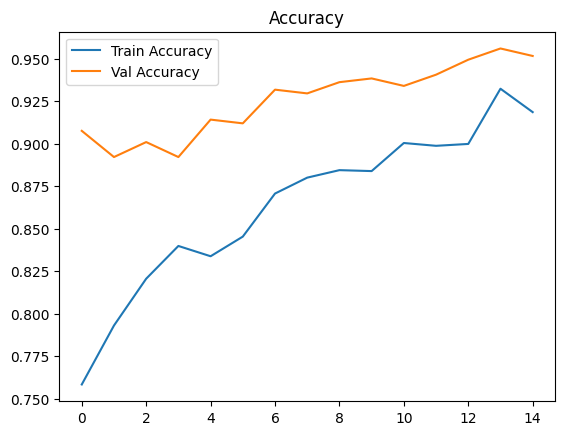

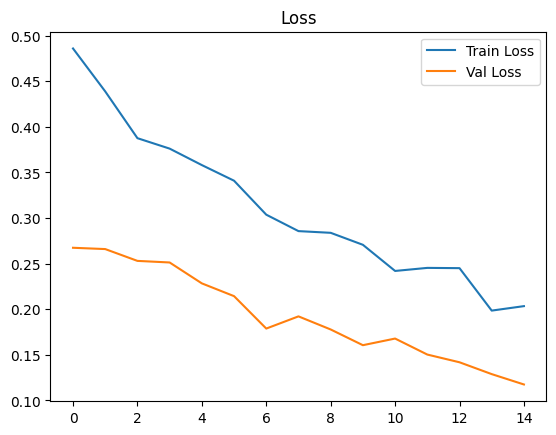


📊 Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 969ms/step



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       231
           1       0.94      0.98      0.96       223

    accuracy                           0.96       454
   macro avg       0.96      0.96      0.96       454
weighted avg       0.96      0.96      0.96       454


Confusion Matrix:
[[218  13]
 [  5 218]]

🎉 TRAINING COMPLETED!
Files saved to: /content/drive/MyDrive/oral_cancer_models


In [1]:
# ==================== IMPORT ====================
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import os
import zipfile
import numpy as np
import json
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# ==================== MOUNT & EXTRACT ====================
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Oral Images Dataset.zip'
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Path dataset
data_dir = os.path.join(
    extract_path,
    "Oral Images Dataset",
    "augmented_data"
)

print("Dataset classes:", os.listdir(data_dir))

# ==================== DATA GENERATORS ====================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

print("Classes:", train_generator.class_indices)

# ==================== CREATE MODEL ====================
def create_model():
    inputs = Input(shape=(224, 224, 3))

    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = create_model()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# ==================== TRAIN TRANSFER LEARNING ====================
print("\n🚀 Training (Transfer Learning)...")
history1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)

# ==================== FINE-TUNING ====================
print("\n🔧 Fine-tuning last layers...")

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)

# ==================== PLOT TRAINING GRAPH ====================
history = history2.history

plt.figure()
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# ==================== EVALUATION ====================
print("\n📊 Evaluating model...")

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = val_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ==================== SAVE MODEL ====================
model_dir = "/content/saved_models"
os.makedirs(model_dir, exist_ok=True)

h5_path = os.path.join(model_dir, "oral_cancer_model.h5")
model.save(h5_path)

json_path = os.path.join(model_dir, "class_info.json")
class_info = {
    'class_indices': train_generator.class_indices,
    'class_names': list(train_generator.class_indices.keys()),
    'input_shape': [224, 224, 3],
    'threshold': 0.5
}

with open(json_path, 'w') as f:
    json.dump(class_info, f, indent=2)

# ==================== COPY TO GOOGLE DRIVE ====================
drive_dir = '/content/drive/MyDrive/oral_cancer_models'
os.makedirs(drive_dir, exist_ok=True)

for filename in os.listdir(model_dir):
    src = os.path.join(model_dir, filename)
    if os.path.isfile(src):   # hanya file
        dst = os.path.join(drive_dir, filename)
        shutil.copy2(src, dst)

print("\n🎉 TRAINING COMPLETED!")
print("Files saved to:", drive_dir)


In [2]:
# ==================== SAVE AS .KERAS ====================
keras_path = os.path.join(model_dir, "oral_cancer_model.keras")
model.save(keras_path)
print("✅ Keras model saved:", keras_path)

# ==================== CONVERT TO TFLITE ====================
print("\n🔄 Converting to TFLite...")

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    tflite_path = os.path.join(model_dir, "oral_cancer_model.tflite")
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    size_mb = os.path.getsize(tflite_path) / 1024 / 1024
    print(f"✅ TFLite model saved: {tflite_path}")
    print(f"📦 Size: {size_mb:.2f} MB")

except Exception as e:
    print("❌ TFLite conversion failed:", e)


✅ Keras model saved: /content/saved_models/oral_cancer_model.keras

🔄 Converting to TFLite...
Saved artifact at '/tmp/tmpprr31n4e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140205549870864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549872016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549872400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549871632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549872208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549872592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549873360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140205549872976: TensorSpec(shape=(), dtype=tf.resource, nam